In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, log
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import os
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import warnings
from tqdm import tqdm 
warnings.filterwarnings('ignore')

In [41]:
work_path = './Downloads/week3'
list_path = os.listdir(work_path)

def create_dataset(company_name, use_return=True):
    # create_dataset function wich specity company_name string value to obtain it time series data
    # use_return: whether use return or price data
    data = pd.read_csv(work_path+f"/{company_name}.csv")
    data['Date'] = pd.to_datetime(data['Date'])
    data['Date'] = data['Date'].dt.tz_localize(None)
    data = data.set_index('Date')
    close_price = data['Close']
    if use_return:
        log_return = np.log(data['Close']/data['Close'].shift(1))
        mean = np.nanmean(log_return)
        log_return[0] = mean
        log_return.name = 'LogReturn'
        return log_return
    else:
        close_price.name = 'Price'
        return close_price
    
data = create_dataset('FPT', False)
# show first 5 rows of dataset
data.head()

Date
2017-01-03    19280.640838
2017-01-04    19452.597501
2017-01-05    19388.113753
2017-01-06    19323.630004
2017-01-09    19431.102918
Name: Price, dtype: float64

## Stationary and White noise test

In [84]:
def stationary_test(data, alpha=.05):
    # Stationary test using Augmented Dickey-Fuller unit root test with
    # H0: a unit root is present in a time series sample
    # H1: unit root is not present in a time series sample
    if(type(data)==list):
        data = np.array(data)
    result = adfuller(data)
    p_value = result[1]
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % (100*result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
	    print('\t%s: %.3f' % (key, value))
    if p_value > alpha:
        print(f'Not enough proof to reject H0: the time series is non-stationary with p-value: {p_value} > {alpha}')
        return False
    print(f'Reject H0: the time series is non-stationary with p-value: {p_value} < {alpha}')
    return True
    
def white_noise_test(errors, alpha=.05):
    # Ljung-Box test of autocorrelation in residuals with
    # H0: The residuals are independently distributed 
    # H1: The residuals are not independently distributed 
    if type(errors) == list:
        errors = np.array(errors)
    nlags = int(log(errors.shape[0]))
    result_df = sm.stats.acorr_ljungbox(errors, lags=[nlags])
    print("White noise test result summary")
    print(result_df)
    p_value = result_df['lb_pvalue'][nlags]
    if p_value > alpha:
        print(f'Not enough proof to reject H0: the residuals are independently distributed with p-value: {p_value} > {alpha}')
        return True
    print(f'Reject H0: the residuals are independently distributed with p-value: {p_value} < {alpha}')
    return False

## ACF and PACF plot

ADF Statistic: 1.388945
p-value: 99.706334
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Not enough proof to reject H0: the time series is non-stationary with p-value: 0.9970633387338833 > 0.05


False

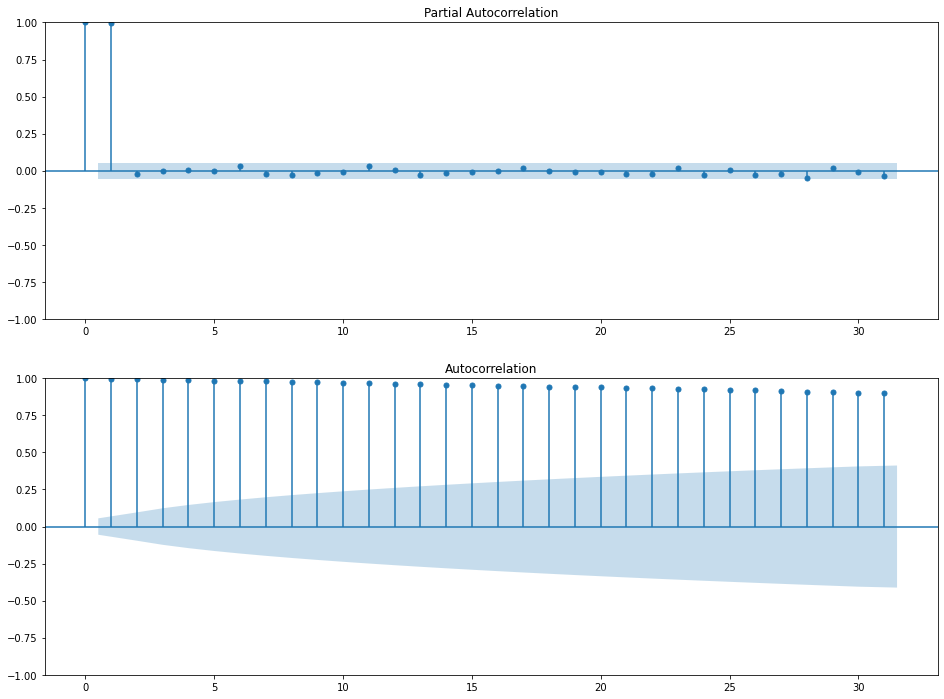

In [87]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 12), nrows=2);
# Plot Partial Autocorrelation function
plot_pacf(data, ax=ax1);
# Plot Autocorrelation function
# From the Autocorrelation graph we can see that the series has positive autocorrelations out to a high number of lags
# We need to take higher order of differencing
plot_acf(data, ax=ax2);
stationary_test(data)

## ARIMA model

In [81]:
window_size = 100
pred_length = 1
# Rolling Window technique
train_data = [data[i:i+window_size] for i in range(len(data)-window_size)]
test_data = [data[i+window_size:i+window_size+pred_length] for i in range(len(data)-window_size-pred_length)]
residuals = []
predictions = []
avg_AIC = 0.0
avg_BIC = 0.0

# Iter through the dataset
for i in tqdm(range(len(test_data))):
    model = ARIMA(train_data[i], order = (1, 1, 1)).fit()
    avg_AIC += model.aic
    avg_BIC += model.bic
    pred = model.forecast(pred_length)
    predictions.append(pred.values[0])
    res = (pred.values-test_data[i].values)[0]
    residuals.append(res)

print('Average AIC results: ', avg_AIC/len(test_data))
print('Average BIC results: ', avg_BIC/len(test_data))

100%|██████████████████████████████████████████████████████████████████████████████| 1154/1154 [02:38<00:00,  7.27it/s]

Average AIC results:  1545.3920989077662
Average BIC results:  1553.177458458171


## Residuals Prediction plot

White noise test result summary
     lb_stat  lb_pvalue
7  20.593689    0.00442
Reject H0: the residuals are independently distributed with p-value: 0.004420439866253658 < 0.05


False

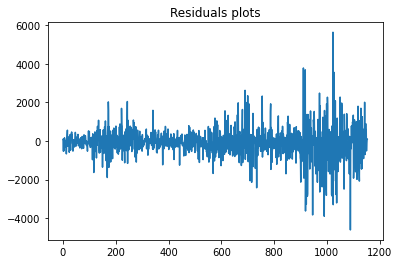

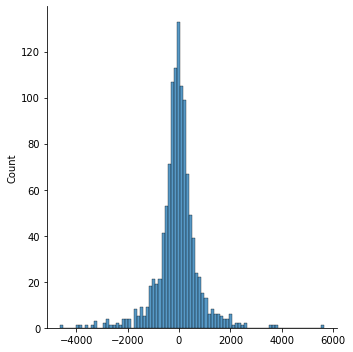

In [82]:
# Residuals plot
plt.plot(residuals);
plt.title('Residuals plots')
# Residuals Distribution plot
sns.displot(residuals)
white_noise_test(residuals)

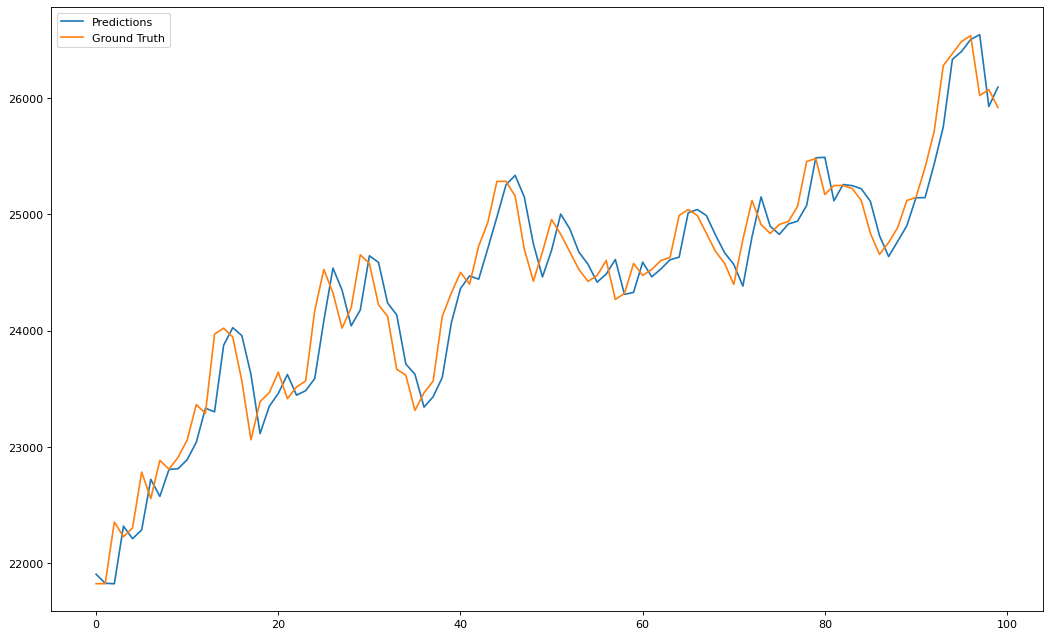

In [83]:
from matplotlib.pyplot import figure
figure(figsize=(16, 10), dpi=80)
# Show difference between first 100 predictions and Ground Truth price
plt.plot(predictions[:100], label='Predictions');
plt.plot(test_data[:100], label='Ground Truth');
plt.legend()